## ===== Part 1: Analyze stock trends =====

Change parameter below

In [1]:
TICKER = "MSFT"
PERIOD = "6mo"  # one of 3mo, 6mo, 1y, 2y

In [2]:
import yfinance as yf

ticker = yf.Ticker(TICKER)
symbol = ticker.info["symbol"]
name = ticker.info["displayName"]
df = ticker.history(period=PERIOD)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-10 00:00:00-05:00,423.003698,423.083378,413.430488,417.345459,20201100,0.0,0.0
2025-01-13 00:00:00-05:00,413.649650,416.897174,410.710966,415.592194,17604800,0.0,0.0
2025-01-14 00:00:00-05:00,416.209822,418.132423,409.146979,414.078033,16935900,0.0,0.0
2025-01-15 00:00:00-05:00,417.524753,426.510195,416.668030,424.677246,19637800,0.0,0.0
2025-01-16 00:00:00-05:00,427.058103,427.845056,422.764613,422.953857,15300000,0.0,0.0


In [3]:
"""Partition stock trends into major changes"""

import numpy as np

from stock_gone_wrong.event.signal import (find_largest_changes,
                                           find_stock_peaks, remove_saddle)

data = df["Close"].to_numpy()
maxima = find_stock_peaks(data, window=2)
minima = find_stock_peaks(-data, window=2)

extrema = np.unique(np.concat(([0, data.size - 1], minima, maxima)))
trends = remove_saddle(data, extrema)
changes = find_largest_changes(data, trends, 5)

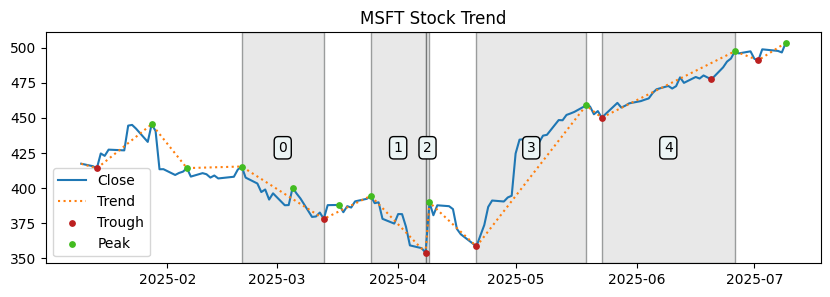

In [4]:
"""Visualize the partition results, and highlight major upturns/downturns"""

from matplotlib import pyplot as plt

plt.figure(figsize=(10, 3))
mid_y = (data.min() + data.max()) / 2
bbox = {
    "facecolor": "#ECF5F5",
    "edgecolor": "black",
    "boxstyle": "round,pad=0.3",
}
for i, (x, y) in enumerate(changes):
    plt.axvspan(
        df.index[x],
        df.index[y],
        facecolor="lightgray",
        edgecolor="#434747",
        alpha=0.5,
        zorder=-10,
    )
    mid_x = df.index[x] + (df.index[y] - df.index[x]) / 2
    plt.text(mid_x, mid_y, f"{i}", ha="center", va="center", zorder=20, bbox=bbox)
plt.plot(df["Close"], label="Close")
plt.plot(df["Close"].iloc[trends], linestyle=":", label="Trend")
plt.scatter(
    df.index[minima], data[minima], s=15, color="#BC2020", zorder=10, label="Trough"
)
plt.scatter(
    df.index[maxima], data[maxima], s=15, color="#42BC20", zorder=10, label="Peak"
)
plt.title(f"{symbol} Stock Trend")
plt.legend()
plt.show()

## ===== Part 2: Explain stock event =====

Change parameter below

In [5]:
CHANGE = 3  # refer to the graph
MODEL = "granite3.2:8b"  # one of installed ollama models, for question answering

In [6]:
from langchain_ollama import ChatOllama

try:
    chat = ChatOllama(model=MODEL)
    response = chat.stream("Who was the first man on the moon?")
    for r in response:
        break
    print("Using ollama models successfully")
except:
    raise RuntimeError(
        "Error in using ollama model. Please make sure it is opened and the model is available"
    ) from None

Using ollama models successfully


In [7]:
"""Search related news on Google"""

from typing import cast

from pandas import Timestamp

from stock_gone_wrong.event.search_news import search_news

change = changes[CHANGE]
start_date = cast(Timestamp, df.index[change[0]])
end_date = cast(Timestamp, df.index[change[1]])
search_results = search_news(f"{name}({symbol}) stock price", start_date, end_date)
print(f"Found {len(search_results)} news")

Found 10 news


In [8]:
"""
Creating embedding and vector store on the fly needs so much time,
so we use a more indexing methods
"""

from langchain_community.retrievers import BM25Retriever

from stock_gone_wrong.event.agent import load_links

links: list[str] = [r.url for r in search_results]
splitted_docs = load_links(links[:5])
retriever = BM25Retriever.from_documents(splitted_docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.
Scrape websites: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


In [ ]:
from stock_gone_wrong.event.agent import model_qa

verb = "rise" if data[change[0]] < data[change[1]] else "drop"
query = f"Why does the stock price of {name} ({symbol}) {verb}?"
response, similar_docs = model_qa(chat, query, retriever)

start_str = start_date.strftime("%Y-%m-%d")
end_str = end_date.strftime("%Y-%m-%d")
print(
    f"Event: {symbol} {verb}s from {data[change[0]]:.2f} in {start_str} to {data[change[1]]:.2f} in {end_str}"
)
print("Query:", query)
source_urls = list(set([d.metadata["source"] for d in similar_docs]))
print("Sources:", source_urls)
print("Response:", end="")
print(response.content)

Event: MSFT rises from 358.46 in 2025-04-21 to 458.87 in 2025-05-19
Query: Why does the stock price of Microsoft (MSFT) rise?
Sources: ['https://www.investopedia.com/why-microsoft-stock-had-one-of-its-best-post-earnings-days-in-a-decade-11726613', 'https://www.markets.com/analysis/3-trending-stocks-analysis-msft-stock-amzn-stock-amd-stock', 'https://www.tastylive.com/news-insights/microsoft-msft-earnings-preview-ai-growth-market-uncertainty']
Response:
The stock price of Microsoft (MSFT) rises due to strong quarterly results that beat Wall Street estimates, with significant growth in its cloud computing unit and other business lines. The low implied volatility for earnings also contributes to this rise, as it indicates less than a 5% expected move despite market uncertainty.